In [75]:
from IPython.display import HTML, Image
HTML('''
    <script src='https://ajax.googleapis.com/ajax/libs/jquery/3.6.1/jquery.min.js'></script>
    <script>
    code_show=false;
    function code_toggle() {
        if (code_show){
        $('div.jp-Editor').show();
        } else {
        $('div.jp-Editor').hide();
    }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
    </script>
    <form action='javascript:code_toggle()'><input type='submit' value='Click here to toggle on/off the raw code.'></form>''')

# NOTE: The text in this notebook does not yet incorporate the changes made in the Google Doc version of the data memo. Charts, however, have all been updated.

# Pre-Storm Values and Road Home Grants

The design of the Road Home program set up the pre-storm value of homes that were damaged or destroyed as a key metric,
one that could serve as a cap on the amount of the grants residents could receive. 

In doing so, the wealthier and Whiter areas of the New Orleans region ended up getting far closer to the amounts they
needed to rebuild, while poorer and less White areas fell further behind.

This analysis looks at areas in New Orleans and St. Bernard that received more than 3 feet of flooding based on 
satelitte imagry from after the levees failed. Road Home grant, pre-storm value and insurance statistics were provided by the state
Division of Administration. Demographic and income data comes from the U.S. Census. 

For privacy reasons, the Division of Administration did not provide grant, insurance or pre-storm value information on U.S. Census blocks that contain fewer than 5 households that received Road Home grants

## Preliminary analysis

This analysis should be considered preliminary while The Times-Picayune, WWL-TV and ProPublica work through some questions about the data with the state Division of Administration. These numbers and analysis may change before publication.

## Preliminary overview

Pre-storm value appears to have had a strong influence on how close Road Home participants came to covering the costs of the damages they incurred. However, this played out differently in New Orleans and St. Bernard.

In New Orleans, there is a direct connection between the total compensation, pre-storm value and both poverty and race. That means that poorer and predominantly Black areas saw far less of their costs covered than wealthier, Whiter areas. This may be due to various historical factors that left Black neighborhoods with lower property values at the time of Katrina.

The picture in St. Bernard is more muddled. St. Bernard residents fared worse at every income level than those in New Orleans. This may be due to the fact that property values in St. Bernard were lower, meaning residents were able to purchase more house for their money. The flip side of that is that the limits imposed by the Road Home program were based on the lower of the pre-storm value or the amount of damage. So people in St. Bernard may have found themselves with homes that were similar to those in wealthier areas of New Orleans -- and, as a result, would have similar rebuilding costs -- but with far lower pricetags. This became a problem when they sustained similar amounts of damage as people in the city, but were only able to recoup a portion of the costs.

## Background

The Road Home program was set up in the aftermath of Hurricane Katrina and Hurricane Rita in 2005 in order to provide funds to Louisiana residents left with homes that had been damaged or destroyed in the storms. The program would eventually grow to a $9 billion effort, the largest housing recovery program in U.S. history, funded by the federal government and administered by the state. 

This analysis focuses on by the largest aspect of the program, known as Option 1, which gave residents money to repair or rebuild their homes. More than 119,000 households in south Louisiana participated in Option 1, while another 12,000 received money through other parts of the program to relocate or rehab their properties as affordable rentals.

Option 1 provided money to homeowners to cover the gap between what they received from insurance companies and 


# Table of contents
* [Introduction](#intro)
* [Methodology](#methodology)
* [Findings](#findings)
    * [Wealthier areas fared better](#wealthier-areas-fared-better)
        * [Uncovered percent by income quintile](#uncovered_percent_by_income_quint)
        * [Uncovered percent by income quintile in New Orleans](#income_quintiles_orleans)
        * [Uncovered percent by income quintile in St. Bernard](#uncoveredbyincomequintstbernard)
        * [Percent of population that is non-Hispanic White by income](#white_percent_by_income)
    * [Charts](#charts)

In [76]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('style/advocate.mplstyle')
%matplotlib inline
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from IPython.display import HTML, Image
HTML('''
    <script src='https://ajax.googleapis.com/ajax/libs/jquery/3.6.1/jquery.min.js'></script>
    <script>
    code_show=false;
    function code_toggle() {
        if (code_show){
        $('div.jp-Editor').show();
        } else {
        $('div.jp-Editor').hide();
    }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
    </script>''')
    # <form action='javascript:code_toggle()'><input type='submit' value='Click here to toggle on/off the raw code.'></form>''')
rh = pd.read_csv('raw data/PRR 8_22_22.csv')
rh = rh.rename(columns = {'Census Block' : 'GEOID'})
rh['GEOID'] = rh['GEOID'].astype(str)
rh = rh.rename(
    columns = {
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'pre_storm_value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }
)


# Import flooding statistics by Census block and generate list of GEOIDs with greater than 3 feet of flooding for filtering
flood_blocks = gpd.read_file('shapefiles/flood_blocks_all/flood_blocks_all.shp')
flood_blocks = flood_blocks[['BLKIDFP00', 'flood_mean', 'flood_medi', 'flood_min', 'flood_max']]
flood_blocks = flood_blocks.rename(columns = {'BLKIDFP00' : 'GEOID', 'flood_medi' : 'flood_median'})
flood_blocks['GEOID'] = flood_blocks['GEOID'].astype(str)
flood_blocks_GT3 = flood_blocks[flood_blocks['flood_min'] > 3]['GEOID'].to_list()

blocks_race = pd.read_csv('raw data/2000-La-HispanicRaceByBlock.csv', skiprows=[0])

# Rename relevant columns for easy reference
blocks_race = blocks_race.rename(
    columns = {
        'Total!!Hispanic or Latino' : 'Hispanic',
        'Total!!Not Hispanic or Latino!!Population of one race!!White alone' : 'White',
        'Total!!Not Hispanic or Latino!!Population of one race!!Black or African American alone' : 'Black',
        'Total!!Not Hispanic or Latino!!Population of one race!!American Indian and Alaska Native alone' : 'Indigenous',
        'Total!!Not Hispanic or Latino!!Population of one race!!Asian alone' : 'Asian',
        'Total!!Not Hispanic or Latino!!Population of one race!!Native Hawaiian and Other Pacific Islander alone' : 'NHOPI',
        'Total!!Not Hispanic or Latino!!Population of one race!!Some other race alone' : 'Other',
        'Total!!Not Hispanic or Latino!!Population of two or more races' : 'Multiracial'
    })
blocks_race = blocks_race[['Total', 'White', 'Black', 'Hispanic', 'Indigenous', 'Asian', 'NHOPI', 'Other', 'Multiracial', 'Geography']]

blocks_race['GEOID'] = blocks_race['Geography'].apply(lambda x: x.split('US')[1])

# Import household statistics based on 2000 Census
households = pd.read_csv('raw data/2000-La-TenureByHouseholderRaceByBlock.csv', skiprows=[0])
households['GEOID'] = households['Geography'].apply(lambda x: x.split('US')[1])
households = households[['GEOID', 'Total', 'Total!!Owner occupied', 'Total!!Owner occupied!!Householder who is Black or African American alone']]
households = households.rename(
    columns =
        {
            'Total' : 'households_2000_total',
            'Total!!Owner occupied' : 'households_2000_owner_occupied',
            'Total!!Owner occupied!!Householder who is Black or African American alone' : 'households_2000_owner_occupied_black'
        })

income = pd.read_csv('processed data/rh_block_groups_all_LA_income_poverty_race_table_3.csv')
income['GEOID'] = income['GEOID'].astype(str)
income = income.rename(columns=
                        {"HAK001": "total_pop",
                        "HA2001":"total_households",
                        "HAQ001": "not_hispanic",
                        "HAQ002": "hispanic",
                        "HAR001":"not_hispanic_white",
                        "HAR002":"not_hispanic_black",
                        "HAR003":"not_hispanic_native",
                        "HAR004":"not_hispanic_asian",
                        "HAR005":"not_hispanic_pacific_islander",
                        "HAR006":"not_hispanic_other",
                        "HAR007":"not_hispanic_two_or_more",
                        "HAR008":"hispanic_white",
                        "HAR009":"hispanic_black",
                        "HAR010":"hispanic_native",
                        "HAR011":"hispanic_asian",
                        "HAR012":"hispanic_pacific_islander",
                        "HAR013":"hispanic_other",
                        "HAR014":"hispanic_two_or_more",
                        "HF5001":"hh_lt_10000",
                        "HF5002":"hh_10000_1499",
                        "HF5003":"hh_15000_19999",
                        "HF5004":"hh_20000_24,999",
                        "HF5005":"hh_25000_29999",
                        "HF5006":"hh_30000_34999",
                        "HF5007":"hh_35000_39999",
                        "HF5008":"hh_40000_44999",
                        "HF5009":"hh_45000_49999",
                        "HF5010":"hh_50000_59999",
                        "HF5011":"hh_60000_74999",
                        "HF5012":"hh_75000_99999",
                        "HF5013":"hh_100000_124999",
                        "HF5014":"hh_125000_149999",
                        "HF5015":"hh_150000_199999",
                        "HF5016":"hh_gte_200000",
                        "HF6001":"hh_median_income",
                        "HHE001":"persons_below_poverty_level",
                        "HHE002":"persons_at_or_below_poverty_level",
                        "HHS001":"hh_below_poverty_level",
                        "HHS002":"hh_at_or_below_poverty_level"}
                    )

rh_flood = (rh[rh['GEOID'].isin(flood_blocks_GT3)]
            .merge(flood_blocks, on='GEOID', how='outer')
            .merge(blocks_race, on='GEOID', how='outer')
            .merge(households, on='GEOID', how='outer'))
rh_flood['CNTYIDFP00'] = rh_flood['GEOID'].str[:5]
rh_flood['BKGPIDFP00'] = rh_flood['GEOID'].str[:12]
rh_flood['TRACTIDFP00'] = rh_flood['GEOID'].str[:11]

rh_flood = rh_flood.rename(
    columns = {
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'pre_storm_value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }


)

rh_all = (rh
            .merge(flood_blocks, on='GEOID', how='outer')
            .merge(blocks_race, on='GEOID', how='outer')
            .merge(households, on='GEOID', how='outer'))
rh_all['CNTYIDFP00'] = rh_all['GEOID'].str[:5]
rh_all['BKGPIDFP00'] = rh_all['GEOID'].str[:12]
rh_all['TRACTIDFP00'] = rh_all['GEOID'].str[:11]

rh_all = rh_all.rename(
    columns = {
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'pre_storm_value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }


)


agg_fields = [
    'compensation_sum',
    'additional_compensation_sum',
    'elevation_sum', 
    'mitigation_sum', 
    'all_grants_sum', 
    'all_grants_count',
    'pre_storm_value_sum', 
    'damage_sum', 
    'insurance_sum',
    'Total', 
    'White', 
    'Black', 
    'Hispanic', 
    'Indigenous', 
    'Asian', 
    'NHOPI',
    'Other', 
    'Multiracial',
    'households_2000_total',
    'households_2000_owner_occupied',
    'households_2000_owner_occupied_black',
]

def helper_fields(df):
    df['damage_mean'] = df['damage_sum'] / df['all_grants_count']
    df['grant_insurance_sum'] = df['compensation_sum']+df['additional_compensation_sum']+df['insurance_sum']
    df['grant_insurance_mean'] = df['grant_insurance_sum']/df['all_grants_count']
    df['cg_insurance_sum'] = df['compensation_sum']+df['insurance_sum']
    df['cg_insurance_mean'] = df['cg_insurance_sum']/df['all_grants_count']
    df['uncovered_sum'] = df['damage_sum'] - df['grant_insurance_sum']
    df['uncovered_mean'] = df['uncovered_sum']/df['all_grants_count']
    df['uncovered_percent'] = (df['damage_sum']-df['grant_insurance_sum'])/df['damage_sum']
    df['cg_uncovered_sum'] = df['damage_sum']-df['cg_insurance_sum']
    df['cg_uncovered_mean'] = df['cg_uncovered_sum']/df['all_grants_count']
    df['cg_uncovered_percent'] = df['cg_uncovered_sum']/df['damage_sum']
    df['pre_storm_value_mean'] = (df['pre_storm_value_sum']/df['all_grants_count'])
    # NOTE: white_percent is calculated using Table 3 IPUMS data
    df['white_percent'] = df['not_hispanic_white']/df['total_pop']
    df['rh_household_pct'] = df['all_grants_count']/df['households_2000_owner_occupied']
    df['households_2000_owner_occupied_pct'] = df['households_2000_owner_occupied']/df['households_2000_total']
    df['households_2000_owner_occupied_black_pct'] = df['households_2000_owner_occupied_black']/df['households_2000_total']
    df['percent_poverty_status'] = df['hh_below_poverty_level']/df['total_households']
    # Buyouts are not yet part of this analysis. Still working on cleaning the St. Bernard geocoding.
    # df['buyouts_households_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']
    # df['buyouts_owner_occupied_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']

    return df

# Changed to rh_all to include all blocks
rh_bg = rh_all.groupby('BKGPIDFP00')[agg_fields].sum()
rh_bg = rh_bg.merge(income, left_on='BKGPIDFP00', right_on='GEOID', how='outer')
rh_bg = helper_fields(rh_bg)
rh_bg['CNTYIDFP00'] = rh_bg['GEOID'].str[:5]
rh_bg['hh_median_income_bin'] = pd.cut(rh_bg['hh_median_income'], bins=[0,20000,40000,60000,80000, 200000])
rh_bg['hh_median_income_quint'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22071', '22087'])) & (rh_bg['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg['hh_median_income_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22071']) & (rh_bg['compensation_sum']>0))]['hh_median_income'], q=5)
rh_bg['hh_median_income_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22087'])) & (rh_bg['compensation_sum']>0)]['hh_median_income'], q=5)

rh_bg['percent_poverty_bins'] = pd.cut(rh_bg['percent_poverty_status'], bins=[0,.2,.4,.6,.8,1])
rh_bg['percent_poverty_quint'] = pd.qcut(rh_bg[rh_bg['compensation_sum']>0]['percent_poverty_status'], q=5)
rh_bg['percent_poverty_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22071']))]['percent_poverty_status'], q=5)
rh_bg['percent_poverty_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22087']))]['percent_poverty_status'], q=5)

rh_bg['white_percent_bins'] = pd.cut(rh_bg['white_percent'], bins=[0,.2,.4,.6,.8,1])
rh_bg['white_percent_quint'] = pd.qcut(rh_bg[rh_bg['compensation_sum']>0]['white_percent'], q=5)
rh_bg['white_percent_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22071']))]['white_percent'], q=5, duplicates='drop')
rh_bg['white_percent_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22087']))]['white_percent'], q=5, duplicates='drop')

rh_bg_all = rh_all.groupby('BKGPIDFP00')[agg_fields].sum()
rh_bg_all = rh_bg_all.merge(income, left_on='BKGPIDFP00', right_on='GEOID', how='outer')
rh_bg_all = helper_fields(rh_bg_all)
rh_bg_all['CNTYIDFP00'] = rh_bg_all['GEOID'].str[:5]
rh_bg_all['hh_median_income_bin'] = pd.cut(rh_bg_all['hh_median_income'], bins=[0,20000,40000,60000,80000,100000,200000])
rh_bg_all['hh_median_income_quint'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22071', '22087'])) & (rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22071']) & (rh_bg_all['compensation_sum']>0))]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22087'])) & (rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)

rh_bg_all['percent_poverty_bins'] = pd.cut(rh_bg_all['percent_poverty_status'], bins=[0,.2,.4,.6,.8,1])
rh_bg_all['percent_poverty_quint'] = pd.qcut(rh_bg_all[rh_bg_all['compensation_sum']>0]['percent_poverty_status'], q=5)
rh_bg_all['percent_poverty_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22071']))]['percent_poverty_status'], q=5)
rh_bg_all['percent_poverty_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22087']))]['percent_poverty_status'], q=5)

rh_bg_all['white_percent_bins'] = pd.cut(rh_bg_all['white_percent'], bins=[0,.2,.4,.6,.8,1])
rh_bg_all['white_percent_quint'] = pd.qcut(rh_bg_all[rh_bg_all['compensation_sum']>0]['white_percent'], q=5)
rh_bg_all['white_percent_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22071']))]['white_percent'], q=5, duplicates='drop')
rh_bg_all['white_percent_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22087']))]['white_percent'], q=5, duplicates='drop')


bg_shp = gpd.read_file('shapefiles/block_groups/orleans_stbernard_bg_no_water.shp')
rh_bg = bg_shp.merge(rh_bg, left_on='BKGPIDFP00', right_on='GEOID', how='outer')
bg_neighborhood = pd.read_csv('processed data/block_groups_neighborhoods.csv')
bg_neighborhood['BKGPIDFP00'] = bg_neighborhood['BKGPIDFP00'].astype(str)
rh_bg = rh_bg.merge(bg_neighborhood, left_on='GEOID', right_on='BKGPIDFP00', how='outer')
rh_neighborhoods = rh_bg[rh_bg['NBHD'].notnull()][agg_fields+['total_pop', 'not_hispanic_white', 'hh_below_poverty_level', 'total_households', 'NBHD']].groupby('NBHD').sum()
rh_neighborhoods = helper_fields(rh_neighborhoods)
rh_neighborhoods_shp = gpd.read_file('shapefiles/neighborhoods/neighborhoods_orleans.shp')
rh_neighborhoods = rh_neighborhoods_shp.merge(rh_neighborhoods, on='NBHD', how='outer')

<a id='intro'></a>

## Introduction

It’s well known that the money given out by the Road Home was insufficient to fully cover the gap between insurance and the amount of damage. But just how lacking it was turned largely on a single factor: how wealthy the homeowner was to begin with. The checks that went to the lowest income residents in the region from insurers and the state would end up covering just barely more than two-thirds the damage to their homes, leaving those least equipped to pay in the most dire straits and with tens of thousands of dollars needed to make up the difference. At the same time, wealthier homeowners saw the largest checks, part of a deliberate design to ensure that people did not receive more than the pre-storm value of their home. In middle-class neighborhoods, residents would see closer to 80% of their costs covered.

Those in the highest income brackets may not have been made completely whole, but they had far less distance to cover. In the wealthiest area of the city, a few blocks in Lakeview where the median income was almost $110,000, only 5% of the damage was left to be covered once the payments from insurance and the Road Home cleared. That meant a relatively tiny gap of about $17,000, a fraction of the $60,000 or more that residents could expect to pay out of pocket on the other end of the scale.

In that wealthy area, it would cost about two months’ salary to complete the repairs. In the poorest neighborhoods, it would take more than six years.
With income and poverty so closely intertwined with race in New Orleans, such dramatic differences meant the Road Home played out far differently if one was Black or White. In Pontchartrain Park, a middle-class Black subdivision near the lakefront that saw catastrophic flooding, homeowners had to scramble to find about $62,000 on average to fix up their homes. To the west in Navarre, an upper-middle-class White neighborhood that saw similar levels of flooding, the average amount of uncovered damage was just $24,000.

And all that is after the state belatedly altered the Road Home program to account for such disparities. The original program paid out money through what were known as Compensation Grants. The latter program, created as a result of a lawsuit alleging discrimination, gave low-income households additional funds through Additional Compensation Grants.

At the same time, the program’s shortcomings were not solely about race. In St. Bernard Parish, a nearly all-White suburb of New Orleans that was nearly completely inundated when the levees failed, lower property values led to payouts that were as far away from covering the cost of repairs regardless of income, often worse than in the worst-off areas of the city.
The toll of such policies continue to reverberate to this day. More than 18 years later, both New Orleans’ Black population and the population of St. Bernard as a whole remain at less than two-thirds the size they were before Katrina.


<a id='methodology'></a>

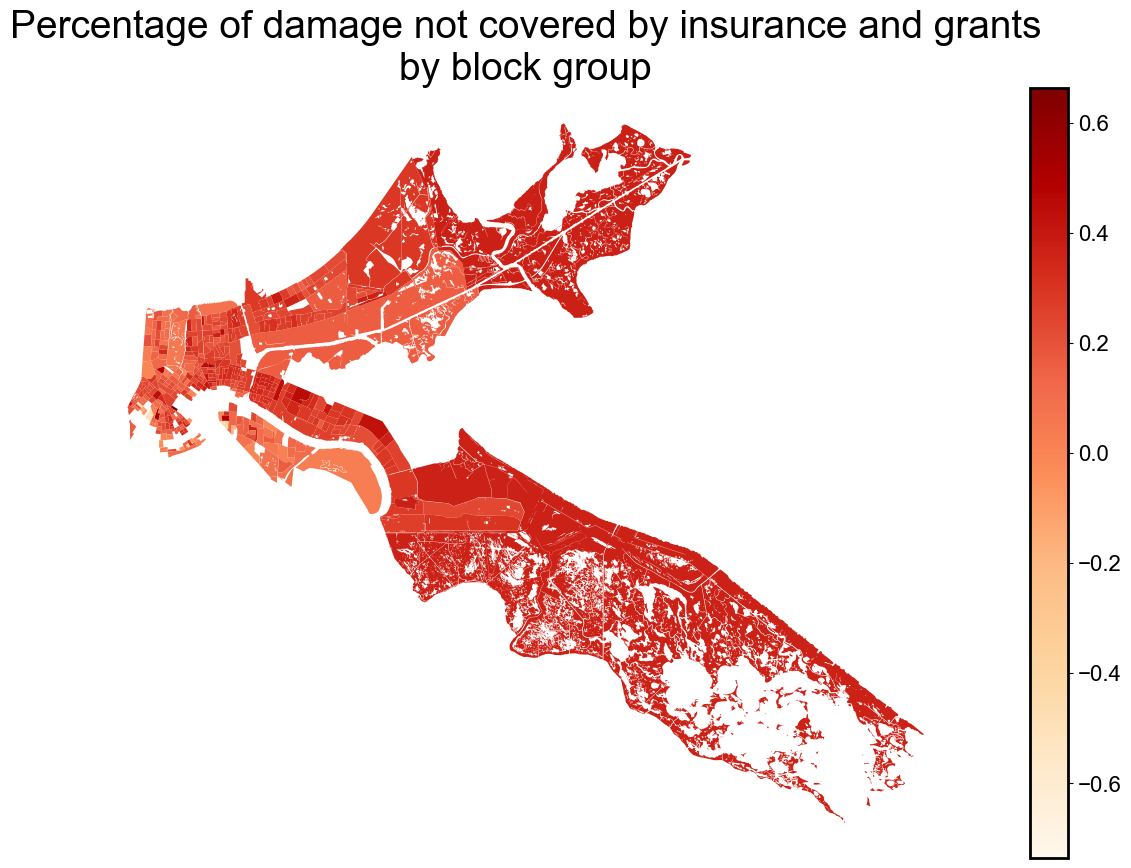

In [77]:
fig, ax = plt.subplots(figsize=(17,10))
rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].plot(column='uncovered_percent', ax=ax, legend=True, cmap='OrRd')
plt.title('Percentage of damage not covered by insurance and grants\nby block group')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

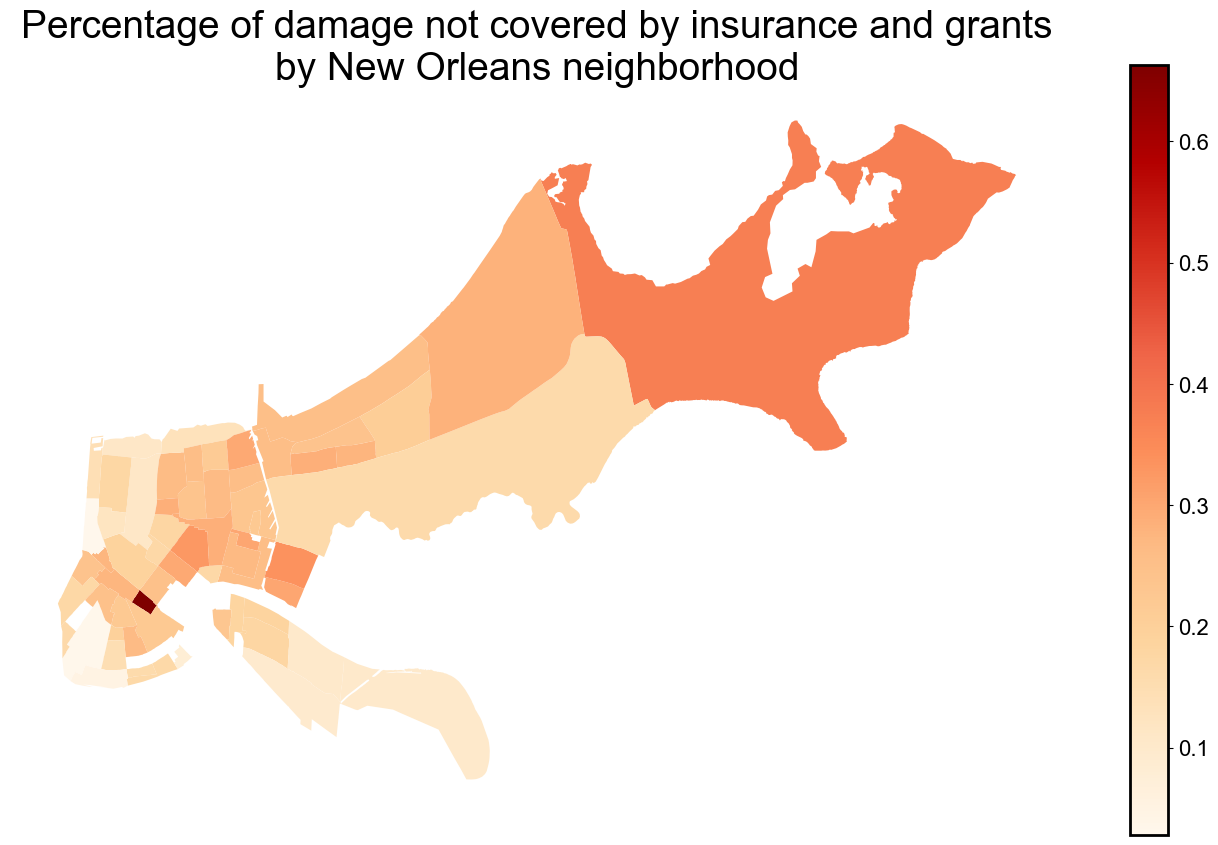

In [78]:
fig, ax = plt.subplots(figsize=(17,10))
rh_neighborhoods[rh_neighborhoods['uncovered_percent']>0].plot(column='uncovered_percent', ax=ax, legend=True, cmap='OrRd')
plt.title('Percentage of damage not covered by insurance and grants\nby New Orleans neighborhood')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

## Methodology:

To evaluate the impacts of the Road Home program, The Times-Picayune and ProPublica used never-before-released data about the program. The data, provided by the state Division of Administration, included the total amount of grants and insurance paid out by Census block — small geographic areas similar in size to city block — as well as the total amount of damage the state estimated those homes had sustained based on a standardized formula.

The state’s data did not include blocks with fewer than five Road Home recipients to protect the privacy of individual homeowners. The Times-Picayune and ProPublica limited its analysis to areas of New Orleans and St. Bernard Parish that saw more than 3 feet of flooding in order to ensure the analysis was comparing areas that were devastated in similar ways.


In [79]:
print("Total number of Road Home grants included in this analysis by parish.")
display(rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])].groupby('CNTYIDFP00')['all_grants_count'].sum().rename(index={'22071' : 'Orleans', '22087' : 'St. Bernard'}))

Total number of Road Home grants included in this analysis by parish.


CNTYIDFP00
Orleans       39,827.00
St. Bernard   11,683.00
Name: all_grants_count, dtype: float64

<a id='findings'></a>

## Findings:

<a id='wealthier_fared_better'></a>
### Wealthier areas fared better
The analysis shows a clear pattern: the wealthier an area was before the flood the better it fared in the aftermath.

Across both New Orleans and St. Bernard, the poorest areas — those with a median income below $18,650 — were left having to cover nearly a third of the cost of the recovery out of their own pockets. In areas where the median income was above $45,000, the gap between the amount of damage and the money paid by the Road Home program was closer to 25%.

Properties in wealthier areas tended to have higher amounts of damage but also received more in grants and insurance to help make them whole.

<a id='uncovered_percent_by_income_quint'></a>

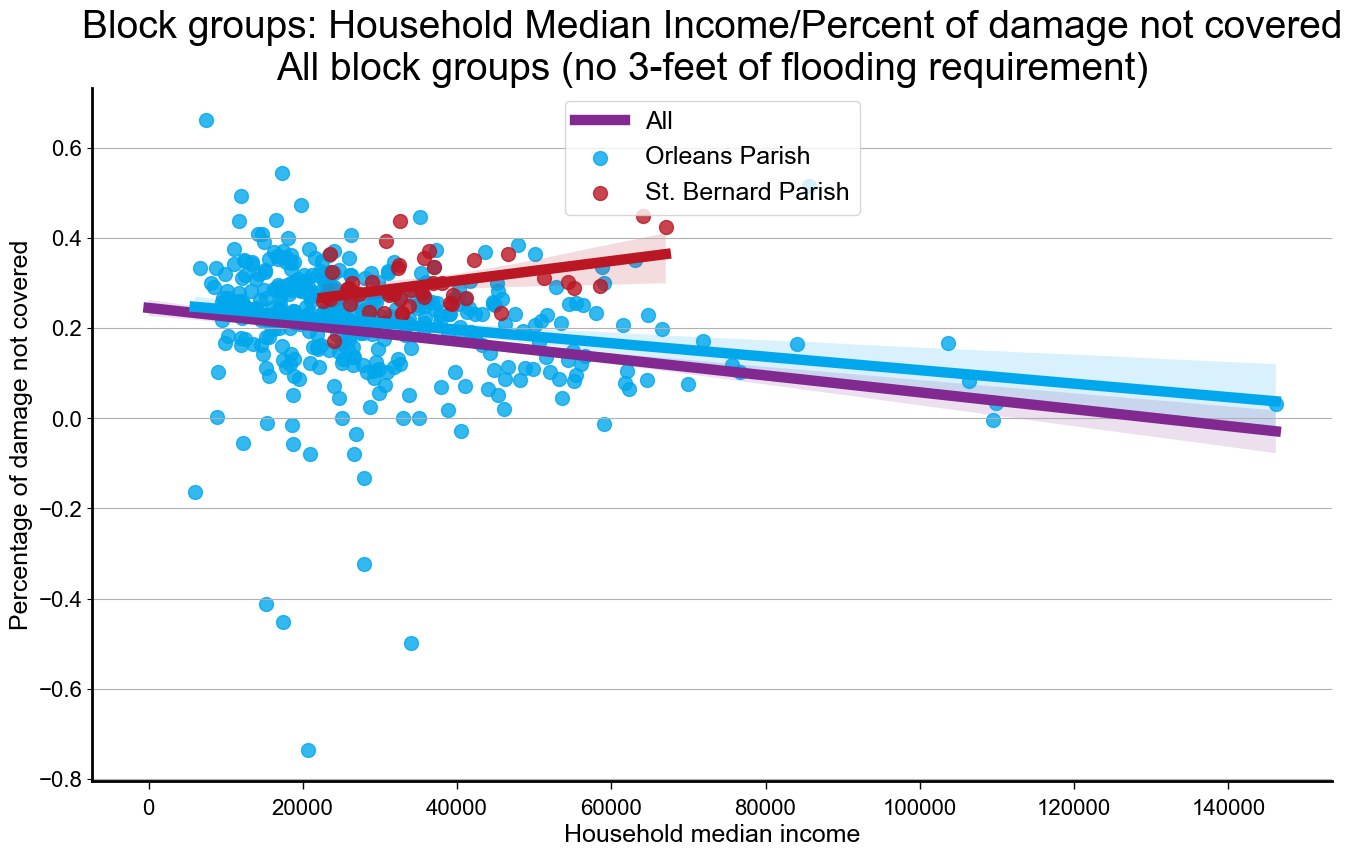

In [115]:
fig, ax = plt.subplots()

sns.regplot(rh_bg[(rh_bg['damage_sum']>0)], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C4'}, 
            scatter=False,
            label='All',
            ax=ax
            )


sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )

sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C1'}, 
            color='C1',
            label='St. Bernard Parish',
            ax=ax
            )
ax.set_xlabel('Household median income')
ax.set_ylabel('Percentage of damage not covered')

plt.title('Block groups: Household Median Income/Percent of damage not covered\nAll block groups (no 3-feet of flooding requirement)')
plt.legend(loc='upper center')
plt.show()
plt.close()

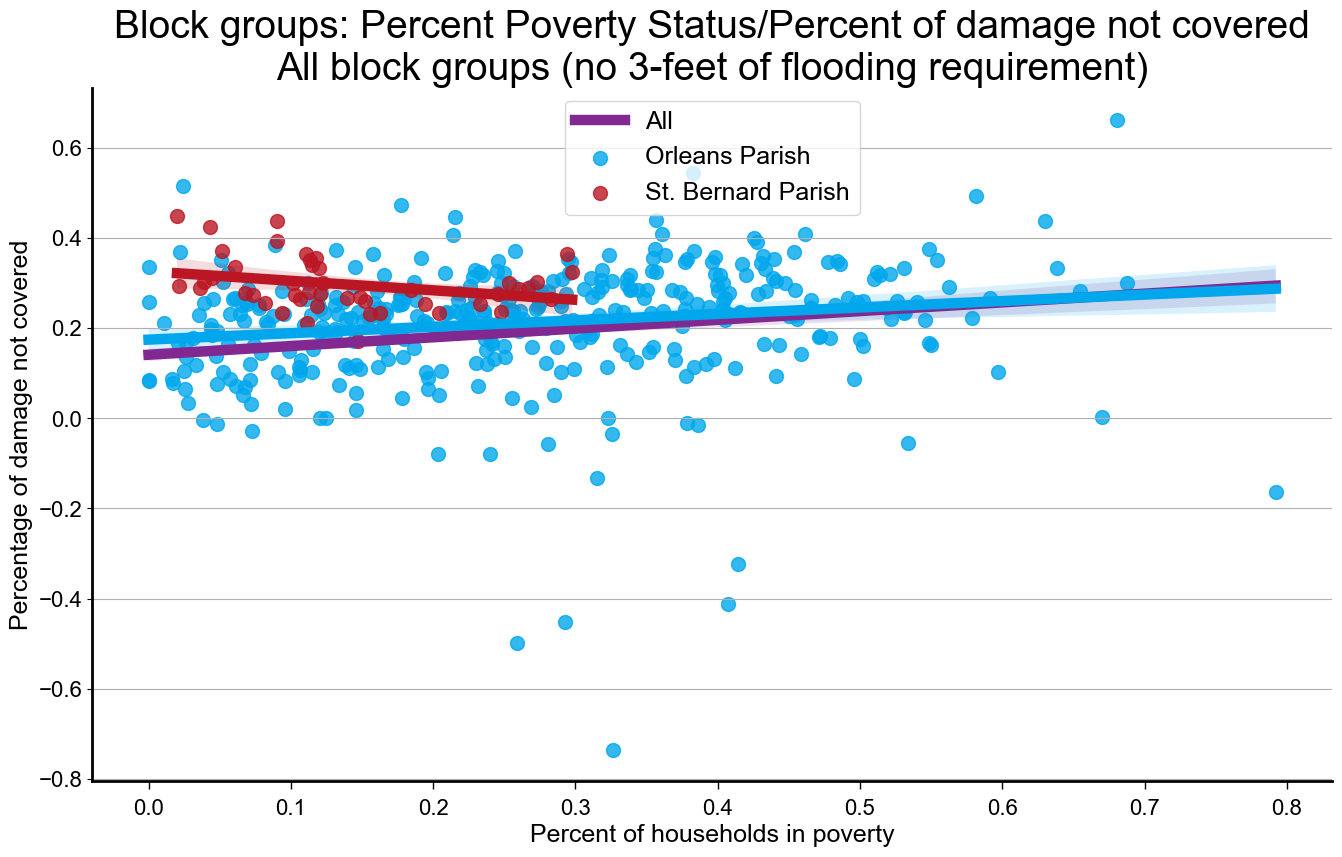

In [117]:
fig, ax = plt.subplots()

sns.regplot(rh_bg[(rh_bg['damage_sum']>0)], 
            x='percent_poverty_status', 
            y='uncovered_percent', 
            line_kws={'color' : 'C4'}, 
            scatter=False,
            label='All',
            ax=ax
            )


sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')], 
            x='percent_poverty_status', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )

sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')], 
            x='percent_poverty_status', 
            y='uncovered_percent', 
            line_kws={'color' : 'C1'}, 
            color='C1',
            label='St. Bernard Parish',
            ax=ax
            )


ax.set_xlabel('Percent of households in poverty')
ax.set_ylabel('Percentage of damage not covered')



# rh_bg[rh_bg['CNTYIDFP00']=='22071'].plot(kind='scatter', x='percent_poverty_status',  y='uncovered_percent', label='Orleans', ax = ax, color='C0')
# rh_bg[rh_bg['CNTYIDFP00']=='22087'].plot(kind='scatter',  x='percent_poverty_status', y='uncovered_percent', label='St. Bernard', ax = ax, color='C1')
plt.title('Block groups: Percent Poverty Status/Percent of damage not covered\nAll block groups (no 3-feet of flooding requirement)')
plt.legend(loc='upper center')
plt.show()
plt.close()

Uncovered percent by income quintiles

In [82]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By income quintiles')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By income quintiles')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1))

By income quintiles


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
hh_median_income_quint,,,,,
"(5984.999, 17202.6]",0.29,"190,394.67","134,879.78","55,514.88","91,068.77"
"(17202.6, 23190.4]",0.28,"177,801.13","128,385.93","49,415.19","81,798.36"
"(23190.4, 29328.8]",0.26,"184,635.42","137,053.25","47,582.17","76,337.50"
"(29328.8, 40353.0]",0.27,"208,603.33","152,886.64","55,716.69","81,289.27"
"(40353.0, 146158.0]",0.25,"245,139.81","183,935.82","61,203.99","75,669.00"


By income quintiles


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
hh_median_income_quint,,,,,
"(5984.999, 17202.6]",0.29,"190,394.67","134,879.78","55,514.88","91,068.77"
"(17202.6, 23190.4]",0.28,"177,801.13","128,385.93","49,415.19","81,798.36"
"(23190.4, 29328.8]",0.26,"184,635.42","137,053.25","47,582.17","76,337.50"
"(29328.8, 40353.0]",0.27,"208,603.33","152,886.64","55,716.69","81,289.27"
"(40353.0, 146158.0]",0.25,"245,139.81","183,935.82","61,203.99","75,669.00"


The same trend is seen if the analyis is expanded to include all available block groups statewide

In [83]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By income quintiles (statewide)')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_quint').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By income buckets (statewide)')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0)].groupby('hh_median_income_bin').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1))

By income quintiles (statewide)


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
hh_median_income_quint,,,,,
"(5984.999, 17202.6]",0.29,"190,394.67","134,879.78","55,514.88","91,068.77"
"(17202.6, 23190.4]",0.28,"177,801.13","128,385.93","49,415.19","81,798.36"
"(23190.4, 29328.8]",0.26,"184,635.42","137,053.25","47,582.17","76,337.50"
"(29328.8, 40353.0]",0.27,"208,603.33","152,886.64","55,716.69","81,289.27"
"(40353.0, 146158.0]",0.25,"245,139.81","183,935.82","61,203.99","75,669.00"


By income buckets (statewide)


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
hh_median_income_bin,,,,,
"(0, 20000]",0.29,"158,172.09","112,375.15","45,796.94","76,793.96"
"(20000, 40000]",0.26,"148,357.30","110,300.13","38,057.17","58,852.90"
"(40000, 60000]",0.22,"165,723.11","128,992.15","36,730.97","48,163.35"
"(60000, 80000]",0.22,"189,732.87","147,391.40","42,341.47","47,707.58"
"(80000, 200000]",0.13,"188,263.34","164,521.72","23,741.62","25,877.71"


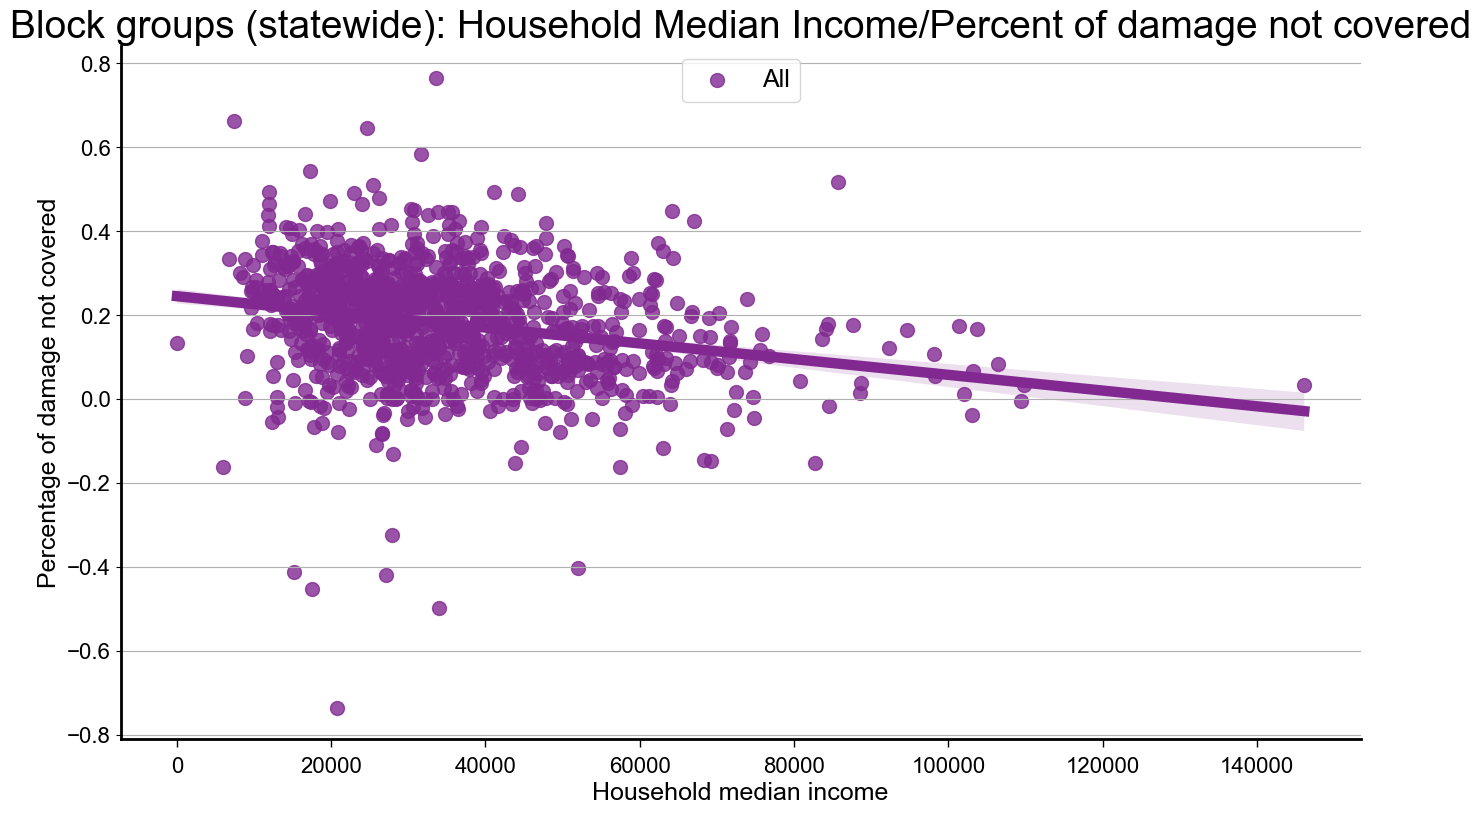

In [84]:
fig, ax = plt.subplots()

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0)], 
            x='hh_median_income', 
            y='uncovered_percent', 
            color='C4',
            # line_kws={'color' : 'C4'}, 
            # scatter=False,
            label='All',
            ax=ax
            )


# sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22071')], 
#             x='hh_median_income', 
#             y='uncovered_percent', 
#             line_kws={'color' : 'C0'}, 
#             color='C0',
#             label='Orleans Parish',
#             ax=ax
#             )

# sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22087')], 
#             x='hh_median_income', 
#             y='uncovered_percent', 
#             line_kws={'color' : 'C1'}, 
#             color='C1',
#             label='St. Bernard Parish',
#             ax=ax
#             )
ax.set_xlabel('Household median income')
ax.set_ylabel('Percentage of damage not covered')


plt.title('Block groups (statewide): Household Median Income/Percent of damage not covered')
plt.legend(loc='upper center')
plt.show()
plt.close()

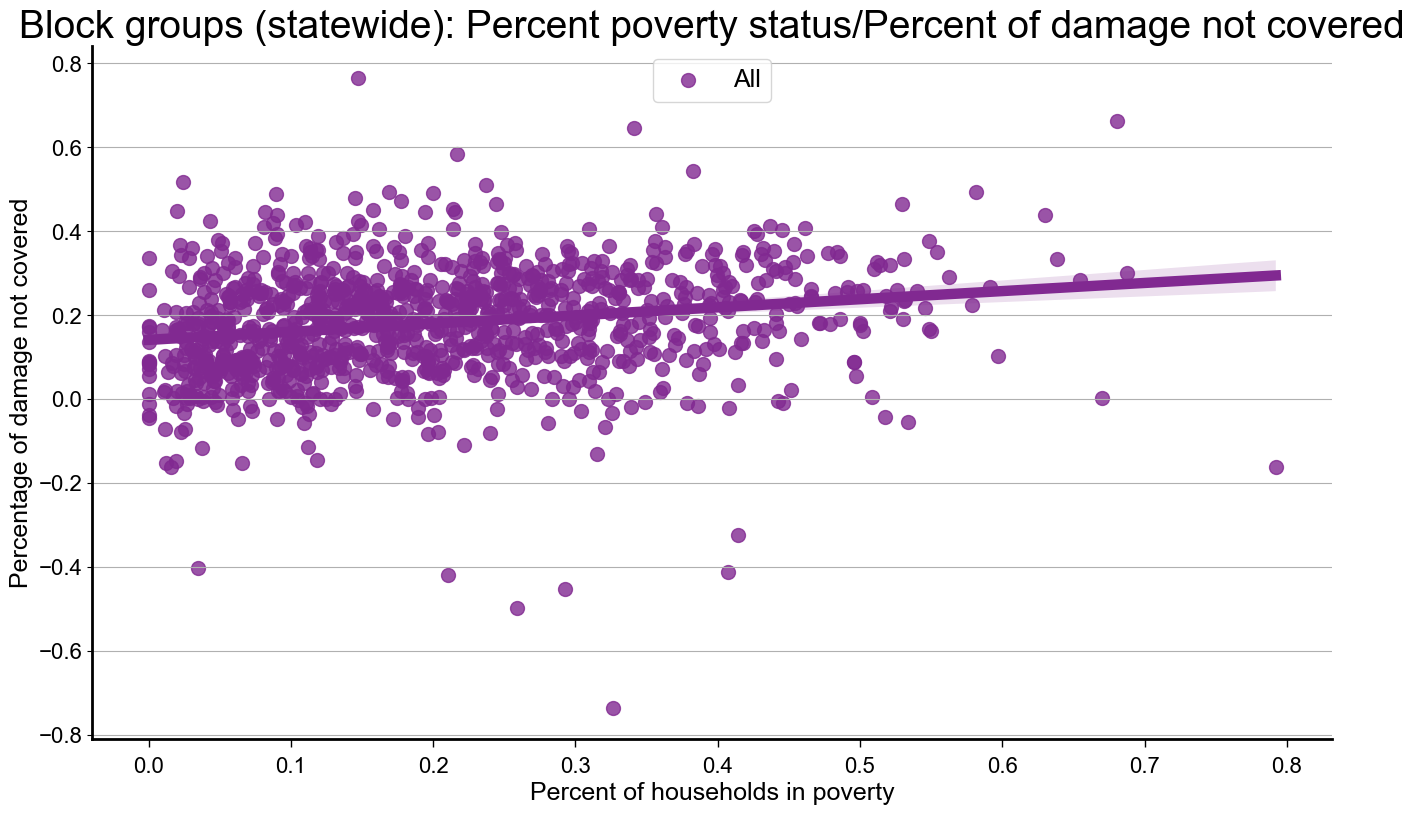

In [85]:
fig, ax = plt.subplots()

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0)], 
            x='percent_poverty_status', 
            y='uncovered_percent', 
            color='C4',
            # line_kws={'color' : 'C4'}, 
            # scatter=False,
            label='All',
            ax=ax
            )


# sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22071')], 
#             x='hh_median_income', 
#             y='uncovered_percent', 
#             line_kws={'color' : 'C0'}, 
#             color='C0',
#             label='Orleans Parish',
#             ax=ax
#             )

# sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22087')], 
#             x='hh_median_income', 
#             y='uncovered_percent', 
#             line_kws={'color' : 'C1'}, 
#             color='C1',
#             label='St. Bernard Parish',
#             ax=ax
#             )
ax.set_xlabel('Percent of households in poverty')
ax.set_ylabel('Percentage of damage not covered')


plt.title('Block groups (statewide): Percent poverty status/Percent of damage not covered')
plt.legend(loc='upper center')
plt.show()
plt.close()

This pattern holds true in New Orleans on its own, but not in St. Bernard.

<a id='#income_quintiles_orleans'></a>

In [86]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By income quintiles (Orleans only)')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_quint_orleans').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_quint_orleans').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_quint_orleans').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_quint_orleans').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_quint_orleans').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By income bins (Orleans only)')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_bin').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_bin').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_bin').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('hh_median_income_bin').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1))


By income quintiles (Orleans only)


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
hh_median_income_quint_orleans,,,,,
"(5984.999, 16617.8]",0.30,"188,473.64","132,602.85","55,870.80","91,181.48"
"(16617.8, 21987.4]",0.28,"187,375.28","134,136.14","53,239.15","87,598.66"
"(21987.4, 27850.6]",0.25,"185,646.04","139,337.32","46,308.72","76,224.08"
"(27850.6, 40221.0]",0.25,"201,352.09","151,494.56","49,857.54","75,426.85"
"(40221.0, 146158.0]",0.22,"238,837.19","186,319.81","52,517.39","67,778.30"


By income bins (Orleans only)


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
hh_median_income_bin,,,,,
"(0, 20000]",0.29,"187,780.21","132,542.40","55,237.81","90,492.10"
"(20000, 40000]",0.25,"195,258.28","146,413.96","48,844.32","76,508.59"
"(40000, 60000]",0.23,"230,665.69","176,905.38","53,760.30","71,523.53"
"(60000, 80000]",0.18,"266,548.36","218,766.58","47,781.78","54,761.73"
"(80000, 200000]",0.14,"250,343.08","214,329.42","36,013.66","38,056.86"


<a id='#income_quintiles_st_bernard'></a>

In [87]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By income quintiles (St. Bernard only)')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('hh_median_income_quint_st_bernard').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('hh_median_income_quint_st_bernard').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('hh_median_income_quint_st_bernard').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('hh_median_income_quint_st_bernard').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('hh_median_income_quint_st_bernard').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1)
        .fillna('-')
    )


By income quintiles (St. Bernard only)


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
hh_median_income_quint_st_bernard,,,,,
"(22599.999, 27313.0]",0.29,"176,374.86","125,665.14","50,709.72","81,087.06"
"(27313.0, 32344.0]",0.27,"194,356.91","141,080.78","53,276.13","74,811.40"
"(32344.0, 35673.0]",0.31,"216,649.04","148,686.99","67,962.05","90,534.01"
"(35673.0, 41198.0]",0.30,"211,215.96","148,008.46","63,207.50","89,075.04"
"(41198.0, 67067.0]",0.36,"271,263.01","174,844.75","96,418.26","111,060.77"


There is a substantial difference in the average pre-storm values in Orleans and St. Bernard at every income level, which likely played a role in St. Bernard's uncovered percentage being higher at every income level.

<a id='#psv_comparison'></a>

In [88]:
display(pd.concat(
    [
        (rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])]
        .groupby(['hh_median_income_bin', 'CNTYIDFP00'])
        .agg({
            'pre_storm_value_sum' : 'sum', 
            'all_grants_count' : 'sum'
            })
        .unstack()
        .apply(lambda x : x['pre_storm_value_sum']/x['all_grants_count'], axis=1))
        .rename(columns = {'22071' : 'Orleans', '22087' : 'St. Bernard'}),

        (rh_bg[rh_bg['CNTYIDFP00'].isin(['22071', '22087'])]
        .groupby('hh_median_income_bin')
        .agg({
            'pre_storm_value_sum' : 'sum', 
            'all_grants_count' : 'sum'})
        .apply(lambda x: (x['pre_storm_value_sum']/x['all_grants_count']), axis=1)
        .rename('All'))

    ],
    axis=1
)
.fillna('-')
.reset_index()
.rename(columns = {'hh_median_income_bin' : 'Household median income range'})
)

,Household median income range,Orleans,St. Bernard,All
0,"(0, 20000]","121,442.45",-,"121,442.45"
1,"(20000, 40000]","139,563.60","119,986.54","133,863.09"
2,"(40000, 60000]","193,147.13","156,425.04","186,342.07"
3,"(60000, 80000]","300,267.56","185,803.14","263,560.15"
4,"(80000, 200000]","428,888.77",-,"428,888.77"


Notably, a comparison of pre-storm values and median income in St. Bernard yields results that are very close to what is seen in areas of New Orleans that have a non-White majority. White majority areas of New Orleans have far higher pre-storm values.


<a id='#psv_comparison_race'></a>

In [89]:
print('Average pre-storm value for Road Home recipients')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    display(pd.concat(
        [
            (rh_bg[
                rh_bg['CNTYIDFP00'].isin(['22071']) & 
                (rh_bg['white_percent'] < .5)
            ]
            .groupby(['hh_median_income_bin'])
            .agg({
                'pre_storm_value_sum' : 'sum', 
                'all_grants_count' : 'sum'
                })
            .apply(lambda x : x['pre_storm_value_sum']/x['all_grants_count'], axis=1))
            .rename('Orleans (non-White majority) '),

            (rh_bg[rh_bg['CNTYIDFP00'].isin(['22087'])]
            .groupby('hh_median_income_bin')
            .agg({
                'pre_storm_value_sum' : 'sum', 
                'all_grants_count' : 'sum'})
            .apply(lambda x: (x['pre_storm_value_sum']/x['all_grants_count']), axis=1)
            .rename('St. Bernard (all)')),
           (rh_bg[
                rh_bg['CNTYIDFP00'].isin(['22071']) & 
                (rh_bg['white_percent'] >= .5)
            ]
            .groupby(['hh_median_income_bin'])
            .agg({
                'pre_storm_value_sum' : 'sum', 
                'all_grants_count' : 'sum'
                })
            .apply(lambda x : x['pre_storm_value_sum']/x['all_grants_count'], axis=1))
            .rename('Orleans (White majority)')


        ],
        axis=1
    )
    .fillna('-')
    .reset_index()
    .rename(columns = {'hh_median_income_bin' : 'Household median income range'})
    )

Average pre-storm value for Road Home recipients


,Household median income range,Orleans (non-White majority),St. Bernard (all),Orleans (White majority)
0,"(0, 20000]","121,377.75",-,"194,956.42"
1,"(20000, 40000]","133,671.30","119,986.54","228,153.44"
2,"(40000, 60000]","151,758.37","156,425.04","281,294.93"
3,"(60000, 80000]","250,570.29","185,803.14","346,492.97"
4,"(80000, 200000]",-,-,"428,888.77"


In [150]:
print(f"Average pre-storm value in St. Bernard: ${rh_bg[rh_bg['CNTYIDFP00']=='22087']['pre_storm_value_sum'].sum()/rh_bg[rh_bg['CNTYIDFP00']=='22087']['all_grants_count'].sum():,.0f}")
print(f"Average pre-storm value in Orleans: ${rh_bg[rh_bg['CNTYIDFP00']=='22071']['pre_storm_value_sum'].sum()/rh_bg[rh_bg['CNTYIDFP00']=='22071']['all_grants_count'].sum():,.0f}")
print(f"Average pre-storm value in Orleans (less than 50% white): ${rh_bg[(rh_bg['CNTYIDFP00']=='22071') & (rh_bg['white_percent']<.5)]['pre_storm_value_sum'].sum()/rh_bg[(rh_bg['CNTYIDFP00']=='22071') & (rh_bg['white_percent']<.5)]['all_grants_count'].sum():,.0f}")
print(f"Average pre-storm value in Orleans (50% white or more): ${rh_bg[(rh_bg['CNTYIDFP00']=='22071') & (rh_bg['white_percent']>=.5)]['pre_storm_value_sum'].sum()/rh_bg[(rh_bg['CNTYIDFP00']=='22071') & (rh_bg['white_percent']>=.5)]['all_grants_count'].sum():,.0f}")



Average pre-storm value in St. Bernard: $132,197
Average pre-storm value in Orleans: $160,623
Average pre-storm value in Orleans (less than 50% white): $138,025
Average pre-storm value in Orleans (50% white or more): $290,851


<a id='#households_in_poverty'></a>

### Households in poverty

Similar trends are seen if the analysis uses percent of households in poverty rather than median income

In [90]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Percent of damage not covered by insurance or grants by percent of households in poverty')
    display(
        pd.concat([
            rh_bg[(rh_bg['compensation_sum']>0)]
                .groupby('percent_poverty_bins')
                .agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'})
                .apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1)
                .rename('All'),
            rh_bg[
                (rh_bg['compensation_sum']>0) &
                (rh_bg['CNTYIDFP00']=='22071')]
                .groupby('percent_poverty_bins')
                .agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'})
                .apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1)
                .rename('Orleans'),
            rh_bg[
                (rh_bg['compensation_sum']>0) &
                (rh_bg['CNTYIDFP00']=='22087')]
                .groupby('percent_poverty_bins')
                .agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'})
                .apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1)
                .rename('St. Bernard')

       ], axis=1)
       .fillna('-')
       .reset_index()
       .rename(columns = {'percent_poverty_bins' : 'Percent of households in poverty'})
    )

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By percent of households in poverty (all)')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) ].groupby('percent_poverty_bins').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) ].groupby('percent_poverty_bins').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0) ].groupby('percent_poverty_bins').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0) ].groupby('percent_poverty_bins').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0) ].groupby('percent_poverty_bins').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1)
        .fillna('-')
    )


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    print('By percent of households in poverty (Orleans only)')
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_bins').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_bins').agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_bins').agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_bins').agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].groupby('percent_poverty_bins').agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
    ], axis=1)
    .fillna('-')
    )


Percent of damage not covered by insurance or grants by percent of households in poverty


,Percent of households in poverty,All,Orleans,St. Bernard
0,"(0.0, 0.2]",0.24,0.23,0.32
1,"(0.2, 0.4]",0.26,0.26,0.29
2,"(0.4, 0.6]",0.29,0.30,-
3,"(0.6, 0.8]",0.32,0.32,-
4,"(0.8, 1.0]",-,-,-


By percent of households in poverty (all)


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
percent_poverty_bins,,,,,
"(0.0, 0.2]",0.24,"163,476.54","124,825.90","38,650.64","52,854.57"
"(0.2, 0.4]",0.26,"143,668.15","106,177.61","37,490.55","62,811.22"
"(0.4, 0.6]",0.29,"150,202.17","105,932.58","44,269.59","73,052.60"
"(0.6, 0.8]",0.32,"201,398.01","137,243.83","64,154.18","99,357.74"
"(0.8, 1.0]",-,-,-,-,-


By percent of households in poverty (Orleans only)


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG)
percent_poverty_bins,,,,,
"(0.0, 0.2]",0.23,"222,397.00","171,125.25","51,271.75","71,136.89"
"(0.2, 0.4]",0.26,"186,640.75","137,334.77","49,305.98","81,422.12"
"(0.4, 0.6]",0.30,"181,995.80","128,078.78","53,917.02","86,845.37"
"(0.6, 0.8]",0.32,"201,398.01","137,243.83","64,154.18","99,357.74"
"(0.8, 1.0]",-,-,-,-,-


<a id='#new_orleans'></a>

### In New Orleans, non-White areas got less of what they needed


In New Orleans, the less White an area was the more damage was left uncovered by grants or insurance. 

Across the city, areas that were less than 50% White received only 67% of the original Compensation Grants, despite sustaining roughly 74% of the total damage tallied by the state. The use of Additional Compensation Grants, which in New Orleans went almost exclusively to areas that had a non-White majority, brought the total share of Road Home money that went to non-White areas up to 76%, slightly more than their share of damage.

However, even that was not enough to fully bring them up to parity with White areas of the city, since the non-White areas only got about 68% of the insurance payouts that went to Road Home recipients.

When all those funding sources are taken into account, about 81% of the damage that was not covered was in areas that were majority non-White.



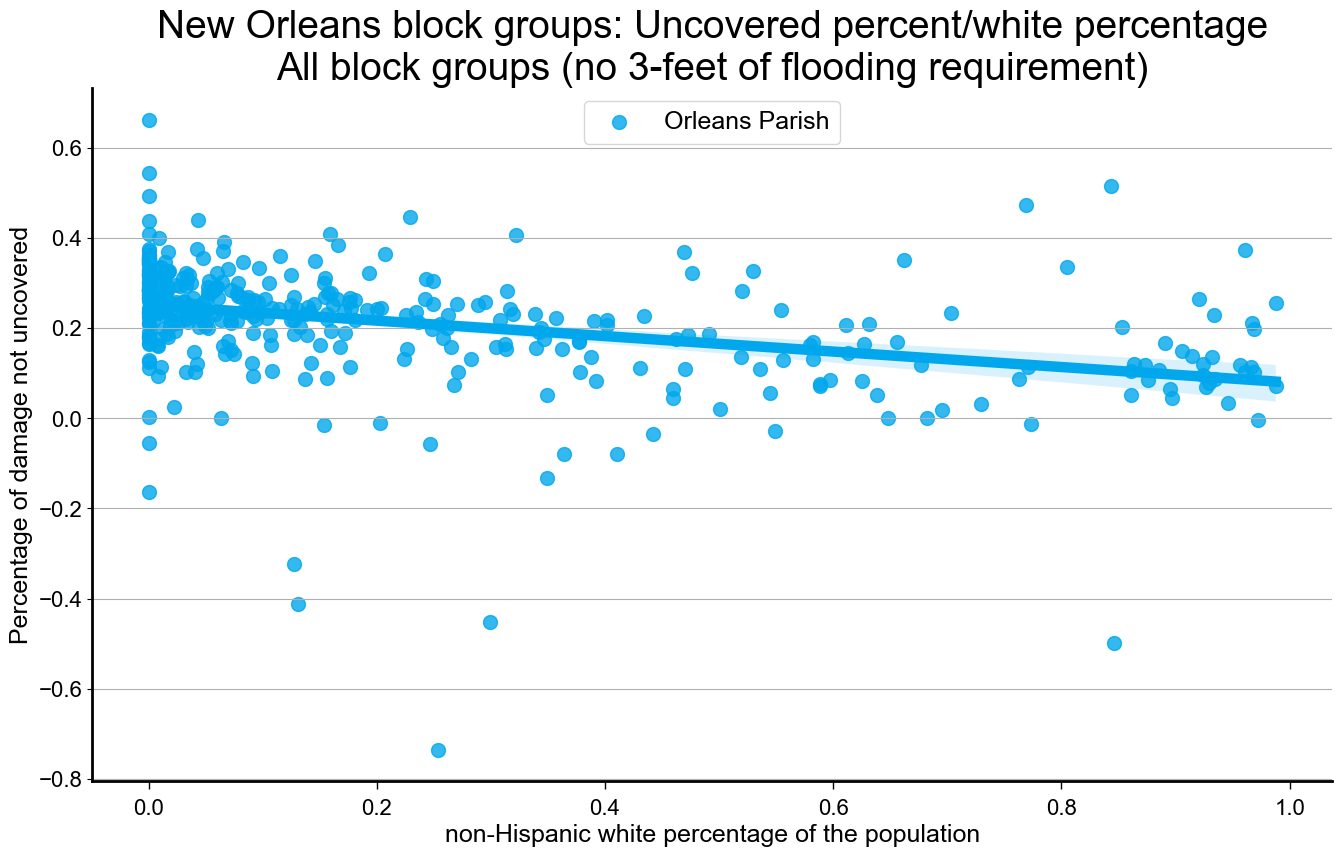

In [118]:
fig, ax = plt.subplots()

sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )
ax.set_xlabel('non-Hispanic white percentage of the population')
ax.set_ylabel('Percentage of damage not uncovered')
plt.title('New Orleans block groups: Uncovered percent/white percentage\nAll block groups (no 3-feet of flooding requirement)')
plt.legend(loc='upper center')
plt.show()
plt.close()

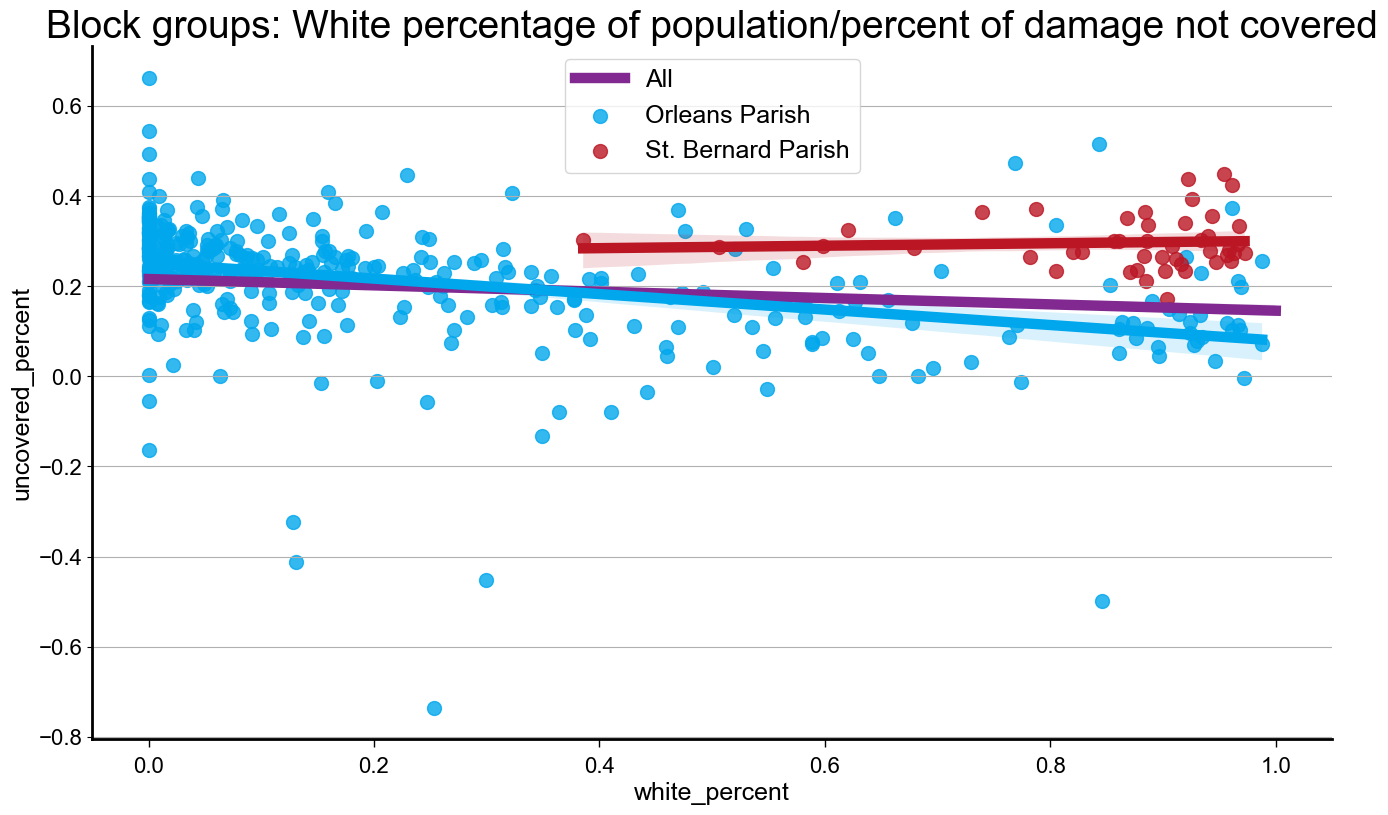

In [92]:
fig, ax = plt.subplots()

sns.regplot(rh_bg[(rh_bg['damage_sum']>0)], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C4'}, 
            scatter=False,
            label='All',
            ax=ax
            )


sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )

sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C1'}, 
            color='C1',
            label='St. Bernard Parish',
            ax=ax
            )



plt.legend(loc='upper center')


# rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')].plot(kind='scatter', x='white_percent', y='uncovered_percent', ax=ax, color='C0')
# rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].plot(kind='scatter', x='white_percent', y='uncovered_percent', ax=ax, color='C1')
plt.title('Block groups: White percentage of population/percent of damage not covered')
plt.show()
plt.close()

Percent of New Orleans population that is non-Hispanic White by income bucket

In [93]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    display(
        rh_bg[
            (rh_bg['compensation_sum']>0) & 
            (rh_bg['CNTYIDFP00']=='22071')
            ]
            .groupby('hh_median_income_bin')
            .agg({
                'total_pop' : 'sum',
                'not_hispanic_white' : 'sum'
                })
            .apply(lambda x: x['not_hispanic_white']/x['total_pop'], axis=1)
            .rename('Percent of population that is non-Hispanic White by income bucket')
    )


hh_median_income_bin
(0, 20000]        0.06
(20000, 40000]    0.19
(40000, 60000]    0.45
(60000, 80000]    0.59
(80000, 200000]   0.77
Name: Percent of population that is non-Hispanic White by income bucket, dtype: float64

In [94]:
print('New Orleans only')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    majority_compare_orleans = (pd.concat([
                                    rh_bg[(rh_bg['white_percent']<=.322) & (rh_bg['CNTYIDFP00']=='22071')][['all_grants_count', 'uncovered_sum', 'damage_sum', 'compensation_sum', 'additional_compensation_sum', 'insurance_sum']].sum().rename('Less than 50% white'),
                                    rh_bg[(rh_bg['white_percent']>.322) & (rh_bg['CNTYIDFP00']=='22071')][['all_grants_count', 'uncovered_sum', 'damage_sum', 'compensation_sum', 'additional_compensation_sum', 'insurance_sum']].sum().rename('50% white or greater')
                                ],
                                axis=1)
                        .transpose())
                                
    majority_compare_orleans['cg_plus_acg_sum'] = majority_compare_orleans['compensation_sum']+majority_compare_orleans['additional_compensation_sum']
    majority_compare_orleans['money_sum'] = majority_compare_orleans['compensation_sum']+majority_compare_orleans['additional_compensation_sum']+majority_compare_orleans['insurance_sum']


    display(
        majority_compare_orleans
        .apply(lambda x: x/x.sum(), axis=0)
        .rename(columns = {
            'all_grants_count' : 'Pct of grants',
            'uncovered_sum' : 'Pct of the total damage not covered by insurance or grants',
            'damage_sum' : 'Pct of total damage',
            'compensation_sum' : 'Pct of Compensation Grants',
            'additional_compensation_sum' : 'Pct of Additional Compensation Grants',
            'cg_plus_acg_sum' : 'Pct of all Road Home money',
            'insurance_sum' : 'Pct of total insurance'
        })
    
    
    )


New Orleans only


,Pct of grants,Pct of the total damage not covered by insurance or grants,Pct of total damage,Pct of Compensation Grants,Pct of Additional Compensation Grants,Pct of total insurance,Pct of all Road Home money,money_sum
Less than 50% white,0.79,0.81,0.76,0.72,0.93,0.71,0.78,0.75
50% white or greater,0.21,0.19,0.24,0.28,0.07,0.29,0.22,0.25


In [95]:
print('New Orleans only')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    majority_compare_orleans = (pd.concat([
                                    rh_bg[(rh_bg['white_percent']<=.322) & (rh_bg['CNTYIDFP00']=='22071')][['all_grants_count', 'uncovered_sum', 'damage_sum', 'compensation_sum', 'additional_compensation_sum', 'insurance_sum']].sum().rename('Less than 50% white'),
                                    rh_bg[(rh_bg['white_percent']>.322) & (rh_bg['CNTYIDFP00']=='22071')][['all_grants_count', 'uncovered_sum', 'damage_sum', 'compensation_sum', 'additional_compensation_sum', 'insurance_sum']].sum().rename('50% white or greater')
                                ],
                                axis=1)
                        .transpose())
                                
    majority_compare_orleans['cg_plus_acg_sum'] = majority_compare_orleans['compensation_sum']+majority_compare_orleans['additional_compensation_sum']
    majority_compare_orleans['cg_plus_acg_sum'] = majority_compare_orleans['compensation_sum']+majority_compare_orleans['additional_compensation_sum']


    display(
        majority_compare_orleans
        .apply(lambda x: x/x.sum(), axis=0)
        .rename(columns = {
            'all_grants_count' : 'Pct of grants',
            'uncovered_sum' : 'Pct of the total damage not covered by insurance or grants',
            'damage_sum' : 'Pct of total damage',
            'compensation_sum' : 'Pct of Compensation Grants',
            'additional_compensation_sum' : 'Pct of Additional Compensation Grants',
            'cg_plus_acg_sum' : 'Pct of all Road Home money',
            'insurance_sum' : 'Pct of total insurance'
        })
    
    
    )

New Orleans only


,Pct of grants,Pct of the total damage not covered by insurance or grants,Pct of total damage,Pct of Compensation Grants,Pct of Additional Compensation Grants,Pct of total insurance,Pct of all Road Home money
Less than 50% white,0.79,0.81,0.76,0.72,0.93,0.71,0.78
50% white or greater,0.21,0.19,0.24,0.28,0.07,0.29,0.22


<a id='#new_orleans_race'></a>

In [96]:
print('Further breakdown by percentage of non-Hispanic White share of population')
display(
    rh_bg[(rh_bg['CNTYIDFP00']=='22071')].groupby('white_percent_bins')[['all_grants_count', 'uncovered_sum', 'damage_sum', 'compensation_sum', 'additional_compensation_sum', 'insurance_sum']].sum()
    .apply(lambda x: x/x.sum(), axis=0)
    .rename(columns = {
            'all_grants_count' : 'Pct of grants',
            'uncovered_sum' : 'Pct of the total damage not covered by insurance or grants',
            'damage_sum' : 'Pct of total damage',
            'compensation_sum' : 'Pct of Compensation Grants',
            'additional_compensation_sum' : 'Pct of Additional Compensation Grants',
            'cg_plus_acg_sum' : 'Pct of all Road Home money',
            'insurance_sum' : 'Pct of total insurance'
            })
    .rename_axis('non-Hispanic White percent of population')
    )

Further breakdown by percentage of non-Hispanic White share of population


,Pct of grants,Pct of the total damage not covered by insurance or grants,Pct of total damage,Pct of Compensation Grants,Pct of Additional Compensation Grants,Pct of total insurance
non-Hispanic White percent of population,,,,,,
"(0.0, 0.2]",0.66,0.68,0.63,0.59,0.82,0.59
"(0.2, 0.4]",0.14,0.14,0.14,0.14,0.12,0.14
"(0.4, 0.6]",0.05,0.03,0.04,0.04,0.02,0.04
"(0.6, 0.8]",0.03,0.03,0.03,0.04,0.01,0.04
"(0.8, 1.0]",0.12,0.12,0.16,0.20,0.03,0.19


Race and income are tightly connected in New Orleans. And property values — the key metric that determined the highest amount that homeowners could get from the program — are even more directly connected within the city.
For example, the typical Road Home property in a middle-class neighborhood that was less than 20% White in 2000 was valued by the program at less than $150,000. In areas with the same income but a population that was 80% White, the value was more than double that.

In the end, those heavily White areas would see 82% of their costs covered by the Road Home program and insurance. The least White areas with the same income would only get checks for 73% of their damage from the program or from private insurance.

(Note: it's not clear why middle-income areas that are from 40% to 60% White have such a high uncovered value - 39%. They also have a higher than expected pre-storm value.)

In [125]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Average pre-storm value in New Orleans based on race and income')
    display(
        rh_bg[
            (rh_bg['compensation_sum']>0) &
            (rh_bg['CNTYIDFP00']=='22071')
            ]
            .groupby(['white_percent_bins', 'hh_median_income_bin'])
            .agg({
                'pre_storm_value_sum' : 'sum',
                'all_grants_count' : 'sum'
                })
            .apply(lambda x: x['pre_storm_value_sum']/x['all_grants_count'], axis=1)
            .unstack()
            .fillna('-')
    )

Average pre-storm value in New Orleans based on race and income


hh_median_income_bin,"(0, 20000]","(20000, 40000]","(40000, 60000]","(60000, 80000]","(80000, 200000]"
white_percent_bins,,,,,
"(0.0, 0.2]","125,399.50","132,729.97","140,865.85","294,202.25",-
"(0.2, 0.4]","155,477.52","153,287.07","164,913.46",-,-
"(0.4, 0.6]",-,"186,336.08","194,839.22","163,837.85",-
"(0.6, 0.8]","194,956.42","289,403.82","216,596.98","260,865.24","251,591.16"
"(0.8, 1.0]",-,"230,537.03","307,372.91","370,048.69","495,375.37"


In [127]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Average uncovered percentage based on race and income')
    display(
        rh_bg[
            (rh_bg['compensation_sum']>0) &
            (rh_bg['CNTYIDFP00']=='22071')
            ]
            .groupby(['white_percent_bins', 'hh_median_income_bin'])
            .agg({
                'uncovered_sum' : 'sum',
                'damage_sum' : 'sum'
                })
            .apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1)
            .unstack()
            .fillna('-')
    )

Average uncovered percentage based on race and income


hh_median_income_bin,"(0, 20000]","(20000, 40000]","(40000, 60000]","(60000, 80000]","(80000, 200000]"
white_percent_bins,,,,,
"(0.0, 0.2]",0.28,0.25,0.27,0.17,-
"(0.2, 0.4]",0.21,0.23,0.26,-,-
"(0.4, 0.6]",-,0.20,0.23,0.17,-
"(0.6, 0.8]",0.47,0.07,0.22,0.35,0.11
"(0.8, 1.0]",-,0.25,0.17,0.14,0.15


In [128]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Average uncovered percentage based on race alone')
    display(
        rh_bg[
            (rh_bg['compensation_sum']>0) &
            (rh_bg['CNTYIDFP00']=='22071')
            ]
            .groupby(['white_percent_bins'])
            .agg({
                'uncovered_sum' : 'sum',
                'damage_sum' : 'sum'
                })
            .apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1)
            .fillna('-')
    )

Average uncovered percentage based on race alone


white_percent_bins
(0.0, 0.2]   0.26
(0.2, 0.4]   0.24
(0.4, 0.6]   0.21
(0.6, 0.8]   0.24
(0.8, 1.0]   0.18
dtype: float64

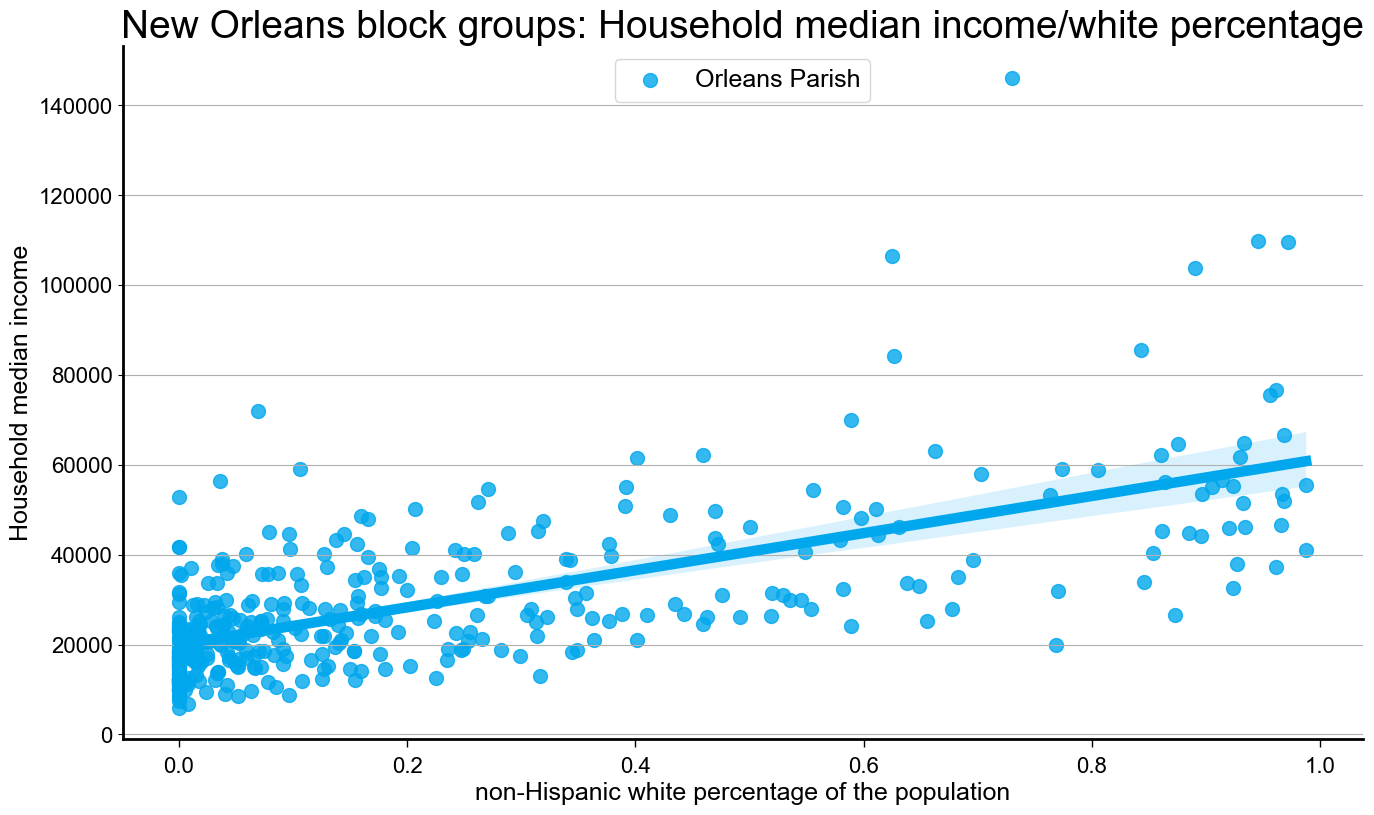

In [129]:
fig, ax = plt.subplots()

sns.regplot(rh_bg[(rh_bg['damage_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')], 
            x='white_percent', 
            y='hh_median_income', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )
ax.set_xlabel('non-Hispanic white percentage of the population')
ax.set_ylabel('Household median income')
plt.title('New Orleans block groups: Household median income/white percentage')
plt.legend(loc='upper center')
plt.show()
plt.close()

In [130]:
rh_bg[(rh_bg['white_percent'].between(.4,.6)) & (rh_bg['hh_median_income'].between(40000,60000)) & (rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22071')][['white_percent', 'hh_median_income', 'all_grants_count', 'uncovered_percent', 'NBHD']].sort_values(by='uncovered_percent')

,white_percent,hh_median_income,all_grants_count,uncovered_percent,NBHD
447,0.55,40563,7.00,-0.03,Bayou St. John
292,0.50,46100,41.00,0.02,Old Aurora
136,0.60,48125,50.00,0.08,Broadmoor
142,0.47,49792,74.00,0.11,Old Aurora
257,0.43,48750,52.00,0.11,Marlyville/Fountainebleau
148,0.56,54375,42.00,0.13,Old Aurora
239,0.58,43281,96.00,0.16,Gentilly Terrace
525,0.58,50583,86.00,0.17,Old Aurora
176,0.47,42292,123.00,0.18,Gentilly Terrace
238,0.47,43661,169.00,0.37,Gentilly Terrace


<a id='#new_orleans_neighborhoods'></a>

### New Orleans by neighborhood

Earlier analysis aggregated block groups by various characteristics. The results on a neighborhood level, which would be more familiar to readers, are similar.

In [131]:
(
    rh_neighborhoods[rh_neighborhoods['damage_sum']>0][
        [   'NBHD',
            'damage_sum', 
            'grant_insurance_sum', 
            'grant_insurance_mean', 
            'uncovered_sum', 
            'uncovered_mean', 
            'uncovered_percent', 
            'white_percent',
            'rh_household_pct',
            'households_2000_owner_occupied_pct'
    ]
]
.sort_values(by='uncovered_percent')
.rename(columns = 
    {
        'damage_sum' : 'Sum of damage',
        'grant_insurance_sum' : 'Sum of grants+insurance',
        'grant_insurance_mean' : 'Mean grants+insurance per property that received grants',
        'uncovered_sum' : 'Total amount left uncovered by grants+insurance',
        'uncovered_mean' : 'Mean amount left uncovered per property that received grants',
        'uncovered_percent' : 'Percent of damage left uncovered',
        'white_percent' : 'Non-Hispanic White population percentage',
        'rh_household_pct' : 'Percent of households that received grants',
        'households_2000_owner_occupied_pct' : 'Percentage of households that were owner occupied (2000)'
    }
)
)

,NBHD,Sum of damage,Sum of grants+insurance,Mean grants+insurance per property that received grants,Total amount left uncovered by grants+insurance,Mean amount left uncovered per property that received grants,Percent of damage left uncovered,Non-Hispanic White population percentage,Percent of households that received grants,Percentage of households that were owner occupied (2000)
20,Fischer Project,"482,237.20","560,594.14","70,074.27","-78,356.94","-9,794.62",-0.16,0.00,0.13,0.12
16,East Carrollton,"902,028.54","994,622.71","62,163.92","-92,594.17","-5,787.14",-0.10,0.64,0.02,0.39
40,Lower Garden District Neighborh,"201,319.67","204,443.63","29,206.23","-3,123.96",-446.28,-0.02,0.57,0.01,0.25
37,Lakewood,"61,986,403.38","60,247,832.30","289,653.04","1,738,571.08","8,358.51",0.03,0.96,0.29,0.92
2,Audubon,"12,321,741.75","11,933,777.78","172,953.30","387,963.97","5,622.67",0.03,0.86,0.02,0.54
72,West Riverside,"362,086.76","344,474.98","26,498.08","17,611.78","1,354.75",0.05,0.58,0.01,0.41
61,St. Thomas Development,"1,675,964.03","1,544,500.04","81,289.48","131,463.99","6,919.16",0.08,0.01,0.22,0.10
62,Tall Timbers/Brechtel,"16,570,327.61","14,981,925.20","53,316.46","1,588,402.41","5,652.68",0.10,0.36,0.16,0.35
50,Old Aurora,"20,941,113.09","18,846,906.26","47,473.32","2,094,206.83","5,275.08",0.10,0.60,0.09,0.74
49,New Aurora/English Turn,"24,402,140.91","21,956,434.12","49,119.54","2,445,706.79","5,471.38",0.10,0.17,0.36,0.73


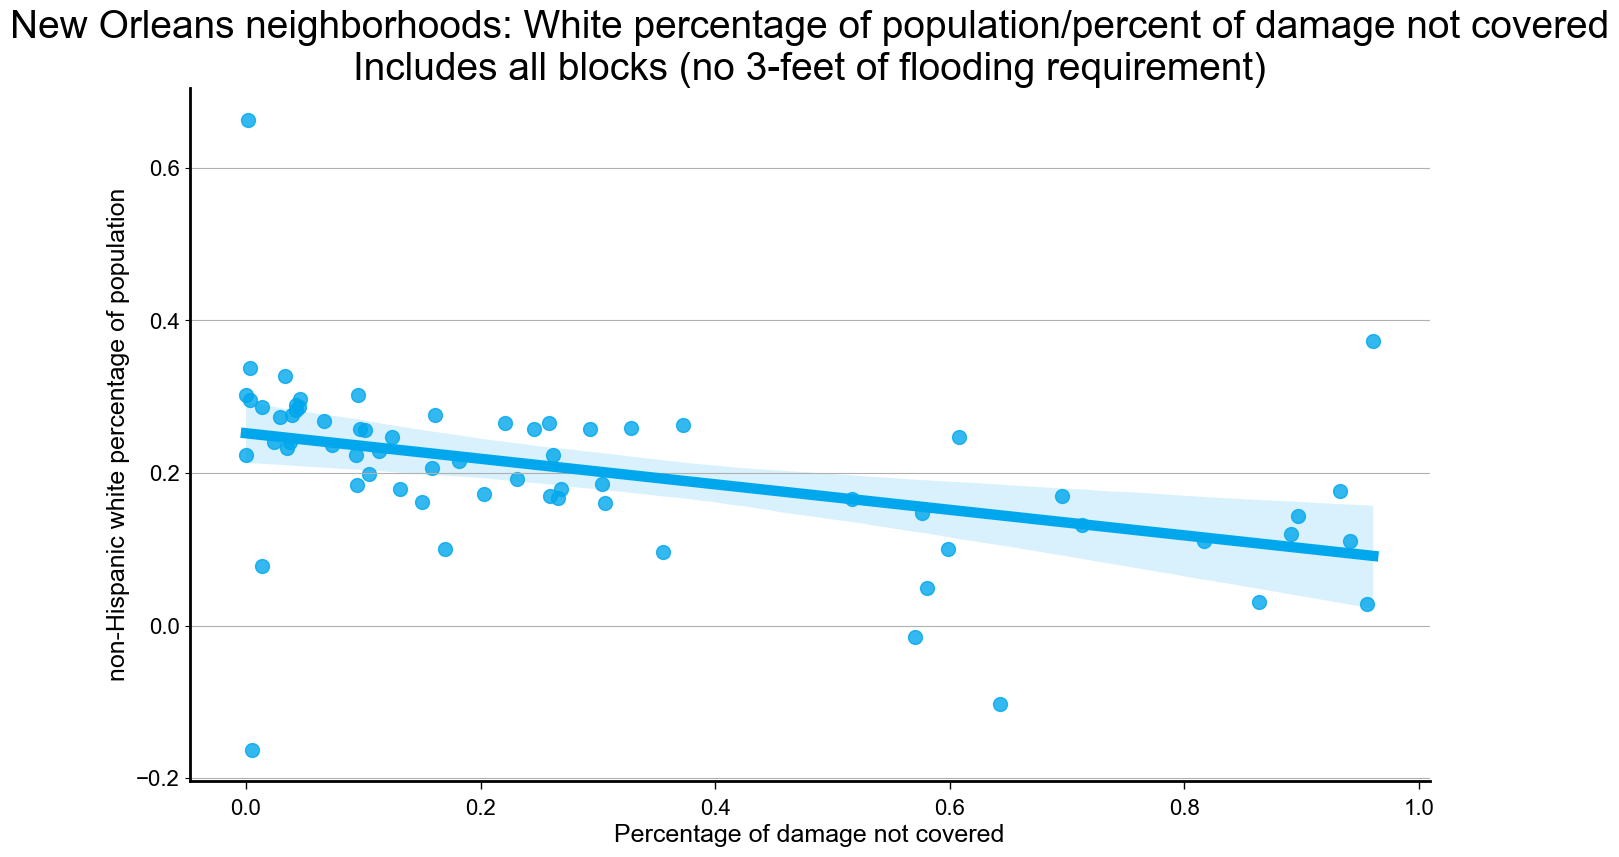

In [132]:
fig, ax = plt.subplots()
sns.regplot(rh_neighborhoods[rh_neighborhoods['damage_sum']>0], x='white_percent', y='uncovered_percent', line_kws={'color' : 'C0'}, ax=ax)
plt.title('New Orleans neighborhoods: White percentage of population/percent of damage not covered\nIncludes all blocks (no 3-feet of flooding requirement)')
ax.set_xlabel('Percentage of damage not covered')
ax.set_ylabel('non-Hispanic white percentage of population')
plt.show()
plt.close()

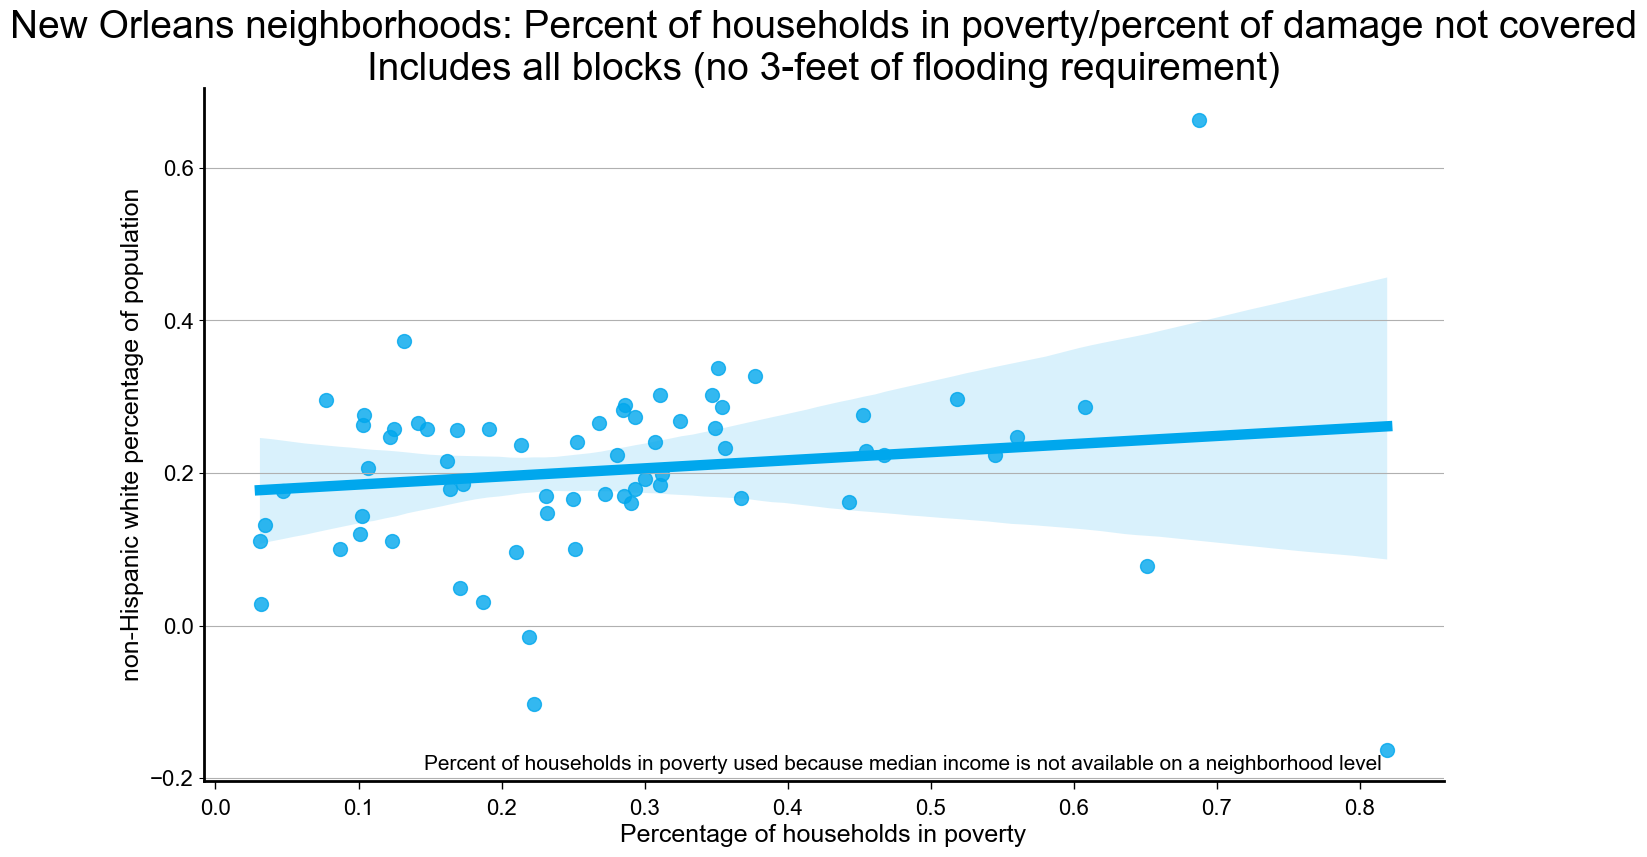

In [133]:
fig, ax = plt.subplots()
sns.regplot(rh_neighborhoods[rh_neighborhoods['damage_sum']>0], x='percent_poverty_status', y='uncovered_percent', line_kws={'color' : 'C0'}, ax=ax)
plt.title('New Orleans neighborhoods: Percent of households in poverty/percent of damage not covered\nIncludes all blocks (no 3-feet of flooding requirement)')
ax.text(0.95, 
        0.01, 
        'Percent of households in poverty used because median income is not available on a neighborhood level',
        verticalalignment='bottom', 
        horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=15)

ax.set_xlabel('Percentage of households in poverty')
ax.set_ylabel('non-Hispanic white percentage of population')
plt.show()
plt.close()

<a id='#insurance'></a>

### Insurance

Insurance, or lack thereof, appears to be another factor in the total amount that residents would have to cover out of their own pockets and this is also related to income. 

About 67% of the compensation for areas in the lowest income quintile came from the Road Home program, either through Compensation or Additional Compensation Grants. In the wealthiest quintile, by contrast, insurance covered 56% of the costs. 

In [104]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(
        rh_bg[(rh_bg['compensation_sum']>0)]
            .groupby('hh_median_income_quint')
            .agg({
                'compensation_sum' : 'sum', 
                'additional_compensation_sum' : 'sum' ,
                'insurance_sum' : 'sum'
                })
            .apply(lambda x: x/x.sum(), axis=1)
            .rename(columns = {
                'compensation_sum' : 'Percent of payment from Compenation Grants',
                'additional_compensation_sum' : 'Percent of payment from Additional Compensation Grants',
                'insurance_sum' : 'Percent of payment from insurance'
                
            }
                )
    )


,Percent of payment from Compenation Grants,Percent of payment from Additional Compensation Grants,Percent of payment from insurance
hh_median_income_quint,,,
"(5984.999, 17202.6]",0.40,0.26,0.34
"(17202.6, 23190.4]",0.42,0.25,0.33
"(23190.4, 29328.8]",0.40,0.21,0.39
"(29328.8, 40353.0]",0.36,0.17,0.47
"(40353.0, 146158.0]",0.37,0.08,0.55


<a id='#acg'></a>

### Effects of Additional Compensation Grants

The additional compensation grants, which aimed to address disparities, can be seen by comparing the amount that wasn't covered when just the original Compensation Grants and insurance were used to the percentages left over after Additional Compensation Grants were factored in. The additional compensation did have a strong effect, however it was not large enough to fully bring more disadvantaged neighborhoods into parity.

(I can provide additional statistics if we want to delve into the disparities under the original formula before Additional Compensation grants were allowed.)

In [141]:
print('Effects of Additional Compensation Grants')
rh_bg['cg_plus_insurance'] = rh_bg['compensation_sum']+rh_bg['insurance_sum']
bg_acg_compare = rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22071', '22087']))].groupby('hh_median_income_bin').agg({'cg_plus_insurance' : 'sum' , 'grant_insurance_sum' : 'sum', 'damage_sum' : 'sum'})
bg_acg_compare['uncovered_percent_cg_insurance'] = 1-(bg_acg_compare['cg_plus_insurance']/bg_acg_compare['damage_sum'])
bg_acg_compare['uncovered_percent'] = 1-(bg_acg_compare['grant_insurance_sum']/bg_acg_compare['damage_sum'])
bg_acg_compare['difference'] = bg_acg_compare['uncovered_percent_cg_insurance']-bg_acg_compare['uncovered_percent']
bg_acg_compare.rename(columns={
    'cg_plu_insurance' : 'Compensation+Insurance only',
    'grant_insurance_sum' : 'Compensation+Additional Compensation+Insurance',
    'damage_sum' : 'Total damage',
    'uncovered_percent_cg_insurance' : 'Percent uncovered with Compensation+Insurance only',
    'uncovered_percent' : 'Percent uncovered with Compensation+Additional Compensation+Insurance',
    'difference' : 'Percentage point difference between C+I and C+AC+I'
})


Effects of Additional Compensation Grants


,cg_plus_insurance,Compensation+Additional Compensation+Insurance,Total damage,Percent uncovered with Compensation+Insurance only,Percent uncovered with Compensation+Additional Compensation+Insurance,Percentage point difference between C+I and C+AC+I
hh_median_income_bin,,,,,,
"(0, 20000]","663,796,776.16","904,336,794.59","1,281,224,345.44",0.48,0.29,0.19
"(20000, 40000]","3,440,097,317.55","4,228,327,675.89","5,742,047,414.27",0.40,0.26,0.14
"(40000, 60000]","1,928,469,098.45","2,140,852,793.64","2,841,356,085.67",0.32,0.25,0.07
"(60000, 80000]","573,532,759.29","598,538,602.43","826,084,582.48",0.31,0.28,0.03
"(80000, 200000]","86,400,494.92","87,232,074.75","101,889,635.25",0.15,0.14,0.01


In [106]:
wo_acg = rh_neighborhoods[rh_neighborhoods['damage_sum']>0][['compensation_sum', 'insurance_sum', 'damage_sum', 'all_grants_count']].apply(lambda x: (x['damage_sum'] - (x['compensation_sum']+x['insurance_sum']))/x['damage_sum'], axis=1).sort_values(ascending=False)
w_acg = rh_neighborhoods[rh_neighborhoods['damage_sum']>0]['uncovered_percent']

acg_compare = pd.concat([wo_acg.rename('Without ACG'), w_acg.rename('With ACG')], axis=1)
acg_compare['Difference'] = acg_compare['Without ACG'] - acg_compare['With ACG']
acg_compare.sort_values(by="Difference")

,Without ACG,With ACG,Difference
40,-0.02,-0.02,0.00
37,0.03,0.03,0.00
2,0.04,0.03,0.01
35,0.12,0.11,0.01
36,0.19,0.18,0.01
34,0.14,0.13,0.01
11,0.13,0.11,0.02
72,0.07,0.05,0.02
48,0.14,0.12,0.02
70,0.16,0.14,0.02


<a id='#acg_race'></a>

In [107]:
print('By white percentage of population')
display(
    pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)]
        .groupby('white_percent_bins')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']))/x['damage_sum'], axis=1)
        .rename('CG and Insurance only'),
        rh_bg[rh_bg['compensation_sum']>0]
        .groupby('white_percent_bins')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'additional_compensation_sum' : 'sum',
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']+x['additional_compensation_sum']))/x['damage_sum'], axis=1)
        .rename('CG, ACG and Insurance')
    ], axis=1)
)


print('By median income')
display(
    pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0)]
        .groupby('hh_median_income_bin')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']))/x['damage_sum'], axis=1)
        .rename('CG and Insurance only'),
        rh_bg[rh_bg['compensation_sum']>0]
        .groupby('hh_median_income_bin')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'additional_compensation_sum' : 'sum',
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']+x['additional_compensation_sum']))/x['damage_sum'], axis=1)
        .rename('CG, ACG and Insurance')
    ], axis=1)
)

By white percentage of population


,CG and Insurance only,"CG, ACG and Insurance"
white_percent_bins,,
"(0.0, 0.2]",0.40,0.25
"(0.2, 0.4]",0.34,0.23
"(0.4, 0.6]",0.35,0.21
"(0.6, 0.8]",0.33,0.23
"(0.8, 1.0]",0.31,0.24


By median income


,CG and Insurance only,"CG, ACG and Insurance"
hh_median_income_bin,,
"(0, 20000]",0.49,0.29
"(20000, 40000]",0.40,0.26
"(40000, 60000]",0.29,0.22
"(60000, 80000]",0.25,0.22
"(80000, 200000]",0.14,0.13


<a id='#st_bernard'></a>

### St. Bernard

The situation is more complicated in St. Bernard, which is more homogenous both in terms of race and income. Pre-storm values were also lower in St. Bernard, generally aligning with the values in non-White New Orleans neighborhoods.

The lower property values appear to be the result of suburban development patterns and slowing growth (the population gained less than 1,000 residents between 1990 and 2000 after nearly tripling from 1950 to 1960 and almost doubling from 1960 to 1980).

This left St. Bernard particularly hurt by a formula that was based around property values. However, that impact was spread across all income brackets. Indeed, it appears higher-end areas of the parish were hurt as much or more as lower-income neighborhoods, possibly because their houses were large enough for the damage estimates to be high but their value was too low.

<a id='uncoveredbyincomebucketstbernard'></a>
Uncovered percent by income bucket (St. Bernard only)

In [151]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
    display(pd.concat([
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('hh_median_income_quint_st_bernard').agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
        rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00']=='22087')].groupby('hh_median_income_quint_st_bernard').size().rename('Count')
    ], axis=1))


,Uncovered Percent,Count
hh_median_income_quint_st_bernard,,
"(22599.999, 27313.0]",0.29,10
"(27313.0, 32344.0]",0.27,9
"(32344.0, 35673.0]",0.31,9
"(35673.0, 41198.0]",0.30,9
"(41198.0, 67067.0]",0.36,9
